# Get patients image size and mask boundings into CSV
* Each script uses only a single GPU, so we will distribute patients among shards in order to distribute or paralellize execution
* For each shard, duplicate this script, set a unique SHARD_ID and execute it
* This script:
   * Creates a directory named "patients-[shard_id]" with all its results
   * Creates a file "patients-analysis.csv" with all imaging analysis data
   * Snapshots 3 slides for each patient to directory "samples"

In [23]:
#only (patient_id%NR_SHARDS) == SHARD_ID will be processed here
#choose a value between 1-NR_SHARDS
SHARD_ID = 1

NR_SHARDS = 4

#Patient DICOM images folder
INPUT_FOLDER = '../../input/sample_images/'
OUTPUT_FOLDER = '../../output/' + str(SHARD_ID) + '/'

In [24]:
%matplotlib inline

import numpy as np # linear algebra
from numpy import ndarray
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statistics
import csv
import dicom
import math
from time import time
import os
import shutil
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.ndimage as ndimage
import itertools
from itertools import product, combinations
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [25]:
class Timer:
    def __init__(self, name, debug=True):
        self._name = name
        self._debug = debug
        self.start()
    
    def start(self):
        self._start = time()
        if(self._debug):
            log('> [started] ' + self._name + '...')

    def stop(self):
        self._lastElapsed = (time()-self._start)
        if(self._debug):
            log('> [done]    {} ({:.3f} ms)'.format(self._name, self._lastElapsed*1000))
            
    def elapsed(self):
        if(self._lastElapsed != None):
            return (self._lastElapsed)
        else:
            return (time()-self._start)

In [26]:
import datetime
def log(message):
    print('{} {}'.format(datetime.datetime.now(), message))

In [27]:
def get_patient_ids(shard_id, input_folder):
  shard_patients = []
  patients = os.listdir(input_folder)
  patients.sort()
  for p in patients:
    if(int(p,16)%NR_SHARDS == (shard_id-1)):
      shard_patients.append(p)
  return shard_patients

In [28]:
# Load the scans in given folder path
#image pixels dimensions: z, y, x
def load_scan(path):
    t = Timer('load_scan ' + path)
    
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.slice_thickness = slice_thickness

    t.stop()
    return slices

In [29]:
#image pixels dimensions: z, y, x
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [30]:
#image pixels dimensions: z, y, x
def resample(image, scan, new_spacing=[1,1,1]):
    t = Timer('resample')
    # Determine current pixel spacing
    spacing = np.array([scan[0].slice_thickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    t.stop()
    
    return image, new_spacing

In [31]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

In [32]:
def segment_lung_mask(image, fill_lung_structures=True):
    t = Timer('segment_lung_mask')

    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)

    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0] 
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2

    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1
    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0

    #dilate mask
    binary_image = scipy.ndimage.morphology.grey_dilation(binary_image, size=(10,10,10))
    t.stop()
    
    return binary_image

In [33]:
#returns ((x1, y1, z1), (x2, y2, z2))
def bounding_box(img):
    N = img.ndim
    out = []
    for ax in itertools.combinations(range(N), N - 1):
        nonzero = np.any(img, axis=ax)
        out.extend(np.where(nonzero)[0][[0, -1]])
    r = np.reshape(np.asarray(tuple(out)), (-1, 2)).T
    return [tuple(r[0]), tuple(r[1])]

In [34]:
#return bounding box center in (x,y,z)
def bounding_box_center(bounds):
    return (int(round((bounds[0][0] + (bounds[1][0]-bounds[0][0])/2))), int(round((bounds[0][1] + (bounds[1][1]-bounds[0][1])/2))), int(round((bounds[0][2] + (bounds[1][2]-bounds[0][2])/2))))

In [35]:
#find lungs rotation by finding minimum and maximum extremities from lung halves
def find_minmax_halfx(lung_mask, xhalf, bottom2up=True, left2right=True, slicen=220):
    xsize = np.shape(lung_mask)[2]-1
    ysize = np.shape(lung_mask)[1]-1
    im = np.swapaxes(lung_mask[slicen], 0, 1)

    if(bottom2up): mvalue = (-1,0)
    else: mvalue = (-1, ysize)
        
    if(left2right): 
        xstart = 0
        xend = xhalf
        xdir = 1
    else:
        xstart = xsize
        xend = xhalf
        xdir = -1
        
    for x in range(xstart, xend, xdir):
        for y in range(ysize):
            if(not bottom2up): yi = ysize - y
            else: yi = y

            if(im[x][yi]>0.5):
                if(bottom2up and yi>mvalue[1]):
                    mvalue = (x, yi)
                elif(not bottom2up and yi<mvalue[1]):
                    mvalue = (x, yi)
    return mvalue
    
def calculate_angle(p1, p2):
    return math.degrees(math.atan2(p2[1]-p1[1],p2[0]-p1[0]))

def value_between(value, min_value, max_value):
    if(value<min_value): return False
    if(value>max_value): return False
    return True

def discover_lung_rotation(lung_mask):
    bbox = bounding_box(lung_mask)
    slicen = int((bbox[1][2]-bbox[0][2])/2)
    half = int(bbox[0][0]+(bbox[1][0]-bbox[0][0])/2)

    l1 = find_minmax_halfx(lung_mask, half, bottom2up=True, left2right=True, slicen=slicen)
    r1 = find_minmax_halfx(lung_mask, half, bottom2up=True, left2right=False, slicen=slicen)
    l2 = find_minmax_halfx(lung_mask, half, bottom2up=False, left2right=True, slicen=slicen)
    r2 = find_minmax_halfx(lung_mask, half, bottom2up=False, left2right=False, slicen=slicen)

    r = (l1, r1, l2, r2)
    xs, ys = zip(*r)
    print(r)
    
    #verify points sanity
    if(not value_between(xs[1]-xs[0], 50, 200) or
       not value_between(xs[3]-xs[2], 50, 200) or
       not value_between(ys[0]-ys[2], 100, 250) or
       not value_between(ys[1]-ys[3], 100, 250)):
        print('Strange rotation detected. returning 0 degrees')
        return 0
    
    angle1 = calculate_angle(l1, r1)
    angle2 = calculate_angle(l2, r2)
    
    fig1, ax1 = plt.subplots(1)
    fig1.set_size_inches(2,2)
    ax1.imshow(lung_mask[slicen], cmap=plt.cm.gray)
    ax1.scatter(xs, ys)
    plt.show()
    
    a = ((angle1 + angle2)/2)
    return a
#     return min(max(a, -10), 10)

# discover_lung_rotation(first_segmented_lungs_fill_dilated)
# discover_lung_rotation(second_segmented_lungs_fill_dilated)

In [36]:
def generate_slice_shot(patient_pixels, patient_lung_mask, patient_id, slice_pos, output_dir):
    t = Timer('generate_slice_shot ' + str(slice_pos))
    fig1, ax1 = plt.subplots(1)
    fig1.set_size_inches(6,6)

    masked_img = np.ma.masked_where(patient_lung_mask[slice_pos]==0, patient_pixels[slice_pos])
    ax1.imshow(masked_img, cmap=plt.cm.gray)

    file = output_dir + patient_id + '-' + 'slice-' + str(slice_pos) + '.jpg'
    plt.savefig(file)
        
#     plt.close(fig1)
    plt.show()
    t.stop()

In [37]:
def generate_patient_info(patient_pixels, patient_lung_mask, patient_scan, patient_id, append_to_csv_file):
    t = Timer('generate_patient_info')
    info = []
    
    #patient_id
    info.append(patient_id)
    
    #image w,h,d
    info.append(np.shape(patient_pixels)[2])
    info.append(np.shape(patient_pixels)[1])
    info.append(np.shape(patient_pixels)[0])
    print(np.shape(patient_pixels))
    
    #image volume mean
    t1 = Timer('flatten pixels')
    data = list(ndarray.flatten(patient_pixels))
    t1.stop()
    t1 = Timer('calc mean')
    info.append(statistics.mean(data))
    t1.stop()
    
    #slice original scan qtty,thickness
    info.append(len(patient_scan))
    info.append(patient_scan[0].slice_thickness)
    
    #lung rotation
    info.append(discover_lung_rotation(patient_lung_mask))
    
    #mask cx,cy,cz,w,h,d
    box = bounding_box(patient_lung_mask)
    box_center = bounding_box_center(box)
    info.append(box_center[0])
    info.append(box_center[1])
    info.append(box_center[2])
    info.append(box[1][0]-box[0][0])
    info.append(box[1][1]-box[0][1])
    info.append(box[1][2]-box[0][2])
    
    #append data to csv file
    with open(append_to_csv_file, 'a') as csvfile:
        writer = csv.writer(csvfile, delimiter=',', quotechar='\'', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(info)
        
    t.stop()

In [38]:
def process_patient(input_dir, patient_id, output_shots_dir, output_csv_file):
    patient_dir = input_dir + patient_id
    patient_scan = load_scan(patient_dir)
    patient_pixels = get_pixels_hu(patient_scan)
    patient_pixels_resampled, spacing = resample(patient_pixels, patient_scan, [1,1,1])
    patient_lung_mask = segment_lung_mask(patient_pixels_resampled, True)
    
    generate_patient_info(patient_pixels_resampled, patient_lung_mask, patient_scan, patient_id, output_csv_file)
    
    ln = np.shape(patient_pixels_resampled)[0]
    generate_slice_shot(patient_pixels_resampled, patient_lung_mask, patient_id, int(ln/4), output_shots_dir)
    generate_slice_shot(patient_pixels_resampled, patient_lung_mask, patient_id, int(ln/4*2), output_shots_dir)
    generate_slice_shot(patient_pixels_resampled, patient_lung_mask, patient_id, int(ln/4*3), output_shots_dir)    

In [39]:
def start_processing(input_dir, shard_id, max_patients, output_dir):
    log('Processing patients. shard_id=' + str(shard_id) + ' max_patients='+ str(max_patients) + ' input_dir=' + input_dir + ' output_dir=' + output_dir)
    patient_ids = get_patient_ids(shard_id, input_dir)
    log('Number of patients: ' + str(len(patient_ids)))
    patients_count = 0
    shutil.rmtree(output_dir, True)
    try:
        os.makedirs(output_dir + 'shots')
    except:
        pass
    
    for patient_id in patient_ids:
        patients_count = patients_count + 1
        if(patients_count>max_patients):
            break
        t = Timer('>>> PATIENT PROCESSING ' + patient_id + ' (count=' + str(patients_count) + '; output_dir=' + output_dir + ')')
        process_patient(input_dir, patient_id, output_dir + 'shots/', output_dir + 'patients.csv')
        t.stop()
        print('')

==== PROCESSING SHARD 1====
2017-02-15 21:32:53.685892 Processing patients. shard_id=1 max_patients=99999 input_dir=../../input/sample_images/ output_dir=../../output/1/
2017-02-15 21:32:53.686583 Number of patients: 3
2017-02-15 21:32:53.709769 > [started] >>> PATIENT PROCESSING 0a099f2549429d29b32f349e95fb2244 (count=1; output_dir=../../output/1/)...
2017-02-15 21:32:53.709839 > [started] load_scan ../../input/sample_images/0a099f2549429d29b32f349e95fb2244...
2017-02-15 21:32:54.680017 > [done]    load_scan ../../input/sample_images/0a099f2549429d29b32f349e95fb2244 (970.141 ms)
2017-02-15 21:32:55.363008 > [started] resample...
2017-02-15 21:33:13.461038 > [done]    resample (18098.001 ms)
2017-02-15 21:33:13.461230 > [started] segment_lung_mask...
2017-02-15 21:33:21.947800 > [done]    segment_lung_mask (8486.532 ms)
2017-02-15 21:33:22.002796 > [started] generate_patient_info...
(320, 347, 347)
2017-02-15 21:33:22.002912 > [started] flatten pixels...
2017-02-15 21:33:26.136784 > [d

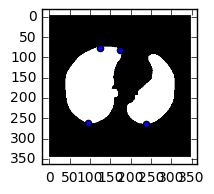

2017-02-15 21:33:50.384343 > [done]    generate_patient_info (28381.534 ms)
2017-02-15 21:33:50.757776 > [started] generate_slice_shot 80...


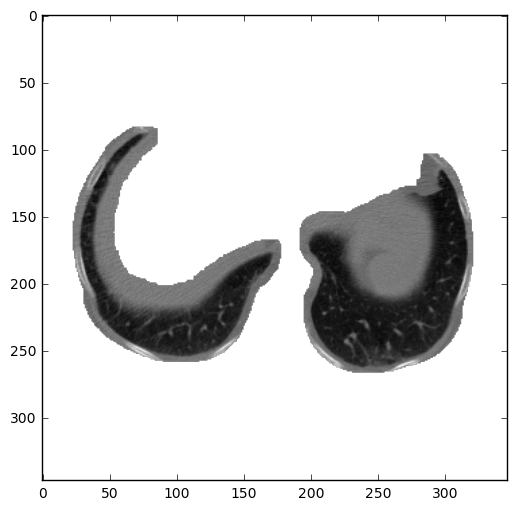

2017-02-15 21:33:51.102562 > [done]    generate_slice_shot 80 (344.779 ms)
2017-02-15 21:33:51.102628 > [started] generate_slice_shot 160...


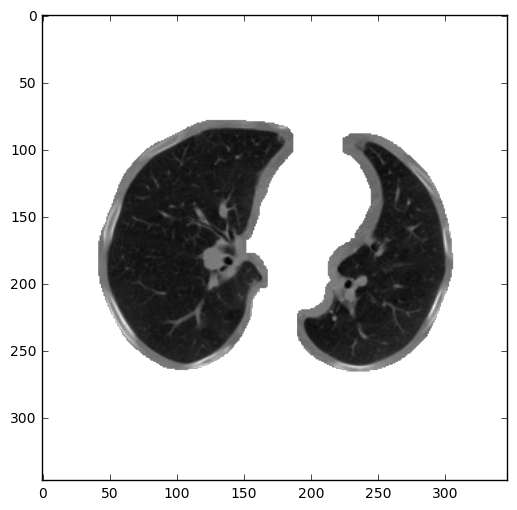

2017-02-15 21:33:51.453978 > [done]    generate_slice_shot 160 (351.337 ms)
2017-02-15 21:33:51.454038 > [started] generate_slice_shot 240...


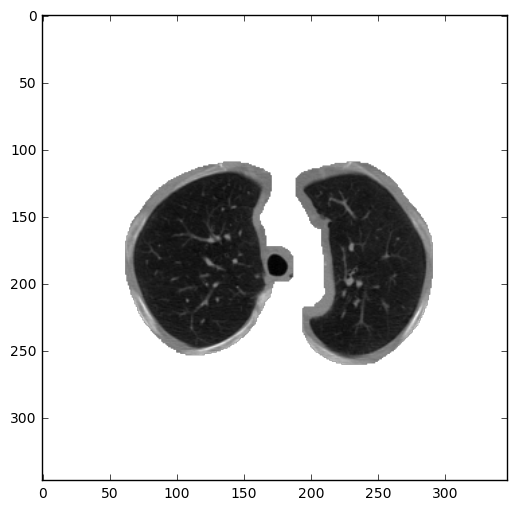

2017-02-15 21:33:51.785108 > [done]    generate_slice_shot 240 (331.055 ms)
2017-02-15 21:33:51.790374 > [done]    >>> PATIENT PROCESSING 0a099f2549429d29b32f349e95fb2244 (count=1; output_dir=../../output/1/) (58080.589 ms)

2017-02-15 21:33:51.790507 > [started] >>> PATIENT PROCESSING 0bd0e3056cbf23a1cb7f0f0b18446068 (count=2; output_dir=../../output/1/)...
2017-02-15 21:33:51.790916 > [started] load_scan ../../input/sample_images/0bd0e3056cbf23a1cb7f0f0b18446068...
2017-02-15 21:33:52.561144 > [done]    load_scan ../../input/sample_images/0bd0e3056cbf23a1cb7f0f0b18446068 (770.209 ms)
2017-02-15 21:33:53.048258 > [started] resample...
2017-02-15 21:34:15.440161 > [done]    resample (22391.893 ms)
2017-02-15 21:34:15.440330 > [started] segment_lung_mask...
2017-02-15 21:34:22.611509 > [done]    segment_lung_mask (7171.124 ms)
2017-02-15 21:34:22.623323 > [started] generate_patient_info...
(350, 340, 340)
2017-02-15 21:34:22.623409 > [started] flatten pixels...
2017-02-15 21:34:25.86230

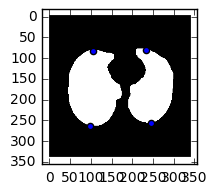

2017-02-15 21:34:52.362543 > [done]    generate_patient_info (29739.209 ms)
2017-02-15 21:34:52.721412 > [started] generate_slice_shot 87...


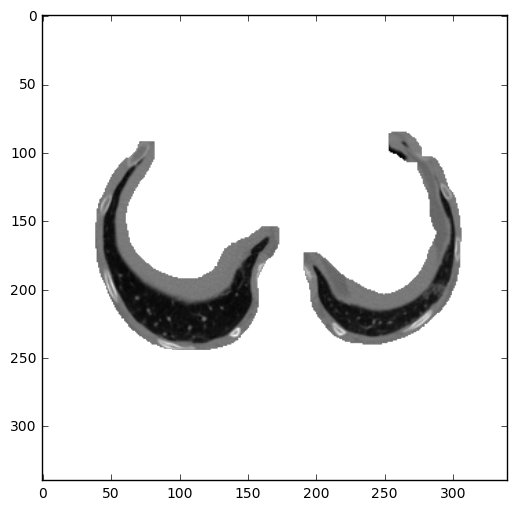

2017-02-15 21:34:53.079045 > [done]    generate_slice_shot 87 (357.624 ms)
2017-02-15 21:34:53.079114 > [started] generate_slice_shot 175...


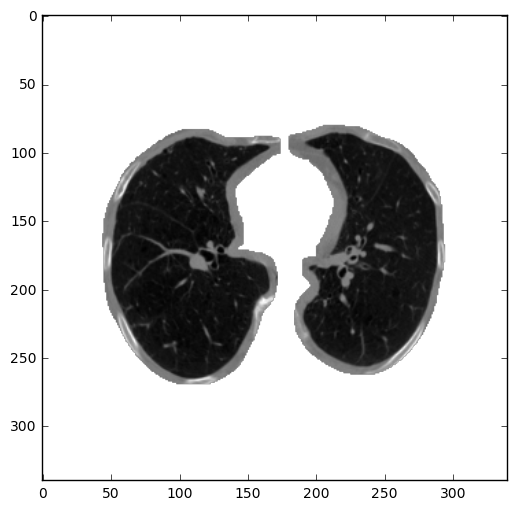

2017-02-15 21:34:53.442051 > [done]    generate_slice_shot 175 (362.916 ms)
2017-02-15 21:34:53.442146 > [started] generate_slice_shot 262...


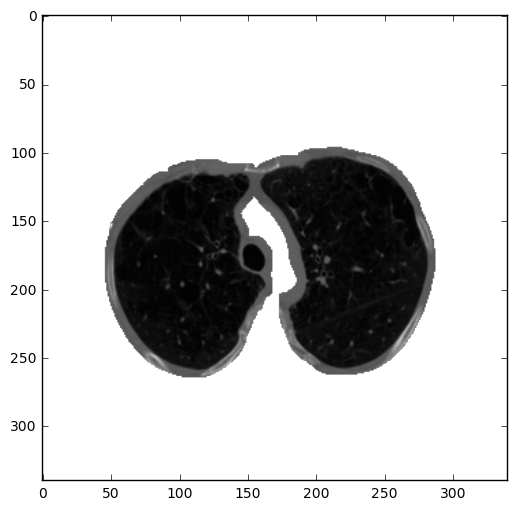

2017-02-15 21:34:53.806302 > [done]    generate_slice_shot 262 (364.139 ms)
2017-02-15 21:34:53.825230 > [done]    >>> PATIENT PROCESSING 0bd0e3056cbf23a1cb7f0f0b18446068 (count=2; output_dir=../../output/1/) (62034.696 ms)

2017-02-15 21:34:53.825347 > [started] >>> PATIENT PROCESSING 0c9d8314f9c69840e25febabb1229fa4 (count=3; output_dir=../../output/1/)...
2017-02-15 21:34:53.825379 > [started] load_scan ../../input/sample_images/0c9d8314f9c69840e25febabb1229fa4...
2017-02-15 21:34:54.190625 > [done]    load_scan ../../input/sample_images/0c9d8314f9c69840e25febabb1229fa4 (365.213 ms)
2017-02-15 21:34:54.516975 > [started] resample...
2017-02-15 21:35:15.161645 > [done]    resample (20644.663 ms)
2017-02-15 21:35:15.161815 > [started] segment_lung_mask...
2017-02-15 21:35:21.801783 > [done]    segment_lung_mask (6639.925 ms)
2017-02-15 21:35:21.812564 > [started] generate_patient_info...
(398, 309, 309)
2017-02-15 21:35:21.812645 > [started] flatten pixels...
2017-02-15 21:35:23.35469

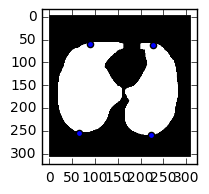

2017-02-15 21:35:49.215873 > [done]    generate_patient_info (27403.310 ms)
2017-02-15 21:35:49.554428 > [started] generate_slice_shot 99...


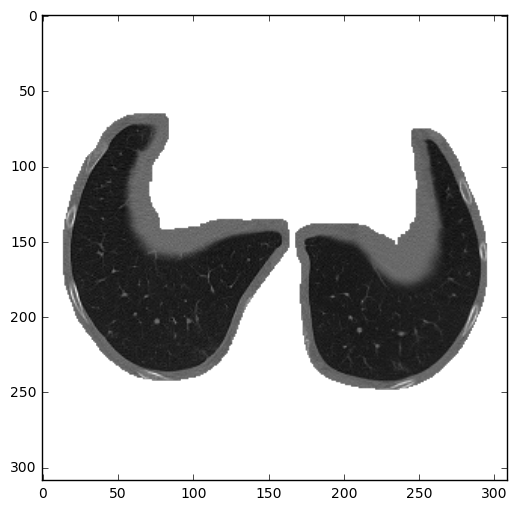

2017-02-15 21:35:49.913141 > [done]    generate_slice_shot 99 (358.705 ms)
2017-02-15 21:35:49.913753 > [started] generate_slice_shot 199...


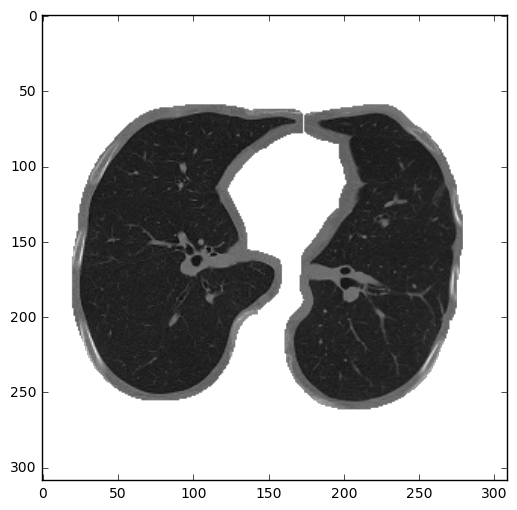

2017-02-15 21:35:50.286422 > [done]    generate_slice_shot 199 (372.654 ms)
2017-02-15 21:35:50.287140 > [started] generate_slice_shot 298...


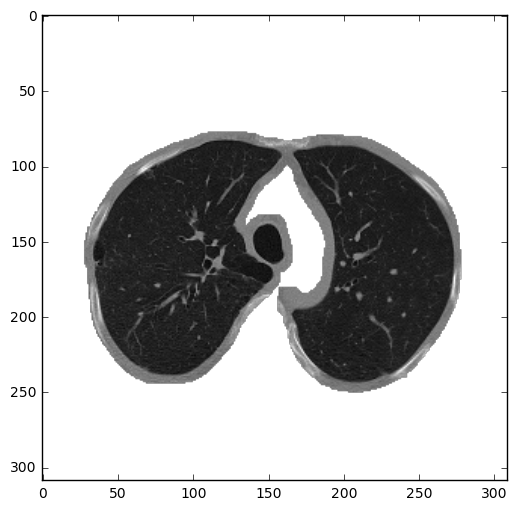

2017-02-15 21:35:50.657877 > [done]    generate_slice_shot 298 (370.716 ms)
2017-02-15 21:35:50.670101 > [done]    >>> PATIENT PROCESSING 0c9d8314f9c69840e25febabb1229fa4 (count=3; output_dir=../../output/1/) (56844.737 ms)

==== ALL DONE ====


In [40]:
print('==== PROCESSING SHARD ' + str(SHARD_ID) + '====')
start_processing(INPUT_FOLDER, SHARD_ID, 99999, OUTPUT_FOLDER)
print('==== ALL DONE ====')